In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
%matplotlib inline

## Serial Baseline Performance

To establish reference performance metrics, we first analyze the three serial implementations across all matrix sizes.

In [2]:
naive_results = pd.concat(
    (pd.read_csv(p) for p in Path("results/naive").glob("*.csv")),
    ignore_index=True,
)

blocked_results = pd.concat(
    (pd.read_csv(p) for p in Path("results/blocked").glob("*.csv")),
    ignore_index=True,
)

openblas_results = pd.concat(
    (pd.read_csv(p) for p in Path("results/blas").glob("*.csv")),
    ignore_index=True,
)

ValueError: No objects to concatenate

In [ ]:
reference_time = naive_results.groupby("size")["time"].mean()

blocked_results = blocked_results.merge(
    reference_time.rename("ref_time"),
    on="size",
)

blocked_results["speedup"] = (
    blocked_results["time"] / blocked_results["ref_time"]
)

openblas_results = openblas_results.merge(
    reference_time.rename("ref_time"),
    on="size",
)

openblas_results["speedup"] = (
    openblas_results["time"] / openblas_results["ref_time"]
)

In [ ]:
units: list[str] = ["s", "ms", "µs", "ns"]

def secs_to_str(secs: float) -> str:
    unit_idx = 0

    while 0.0 < secs < 1.0:
        secs *= 1000.0
        unit_idx += 1
    
    return f"{secs:.2f} {units[unit_idx]}"

def speedup_to_str(speedup: float) -> str:
    return f"{speedup:.2f}x"


In [ ]:
summary_table = pd.DataFrame()
summary_table["size"] = np.sort(naive_results["size"].unique())

summary_table["naive_time"] = naive_results.groupby("size")["time"].mean().to_numpy()
summary_table["best_blocked_time"] = blocked_results.groupby(["size", "block_size"], as_index=False)['time'].mean().groupby('size')['time'].min().to_numpy()
summary_table["best_blocked_speedup"] = summary_table["naive_time"] / summary_table["best_blocked_time"]
summary_table["openblas_time"] = openblas_results.groupby("size")["time"].mean().to_numpy()
summary_table["openblas_speedup"] = summary_table["naive_time"] / summary_table["openblas_time"]

summary_table["best_blocked_speedup"] = summary_table["best_blocked_speedup"].apply(speedup_to_str)
summary_table["openblas_speedup"] = summary_table["openblas_speedup"].apply(speedup_to_str)

summary_table["naive_time"] = summary_table["naive_time"].apply(secs_to_str)

summary_table["best_blocked_time"] = summary_table["best_blocked_time"].apply(secs_to_str)
summary_table["best_blocked_time"] = summary_table["best_blocked_time"] + " (" + summary_table["best_blocked_speedup"] + ")"

summary_table["openblas_time"] = summary_table["openblas_time"].apply(secs_to_str)
summary_table["openblas_time"] = summary_table["openblas_time"] + " (" + summary_table["openblas_speedup"] + ")"

del summary_table["best_blocked_speedup"]
del summary_table["openblas_speedup"]

print(summary_table.to_latex(index=False, ))

\begin{tabular}{rlll}
\toprule
size & naive_time & best_blocked_time & openblas_time \\
\midrule
4 & 116.57 ns & 67.70 ns (1.72x) & 98.13 ns (1.19x) \\
8 & 252.47 ns & 220.23 ns (1.15x) & 120.17 ns (2.10x) \\
16 & 702.73 ns & 673.53 ns (1.04x) & 402.53 ns (1.75x) \\
32 & 3.67 µs & 4.04 µs (0.91x) & 903.07 ns (4.06x) \\
64 & 24.30 µs & 23.73 µs (1.02x) & 6.04 µs (4.02x) \\
128 & 177.14 µs & 189.59 µs (0.93x) & 42.15 µs (4.20x) \\
256 & 1.56 ms & 1.74 ms (0.90x) & 366.89 µs (4.24x) \\
512 & 10.44 ms & 13.99 ms (0.75x) & 2.43 ms (4.29x) \\
1024 & 158.28 ms & 99.81 ms (1.59x) & 17.92 ms (8.83x) \\
2048 & 1.09 s & 838.53 ms (1.30x) & 141.54 ms (7.72x) \\
4096 & 9.74 s & 8.04 s (1.21x) & 1.11 s (8.74x) \\
\bottomrule
\end{tabular}



FileNotFoundError: [Errno 2] No such file or directory: 'figures/matrix_multiplication_performance.pdf'

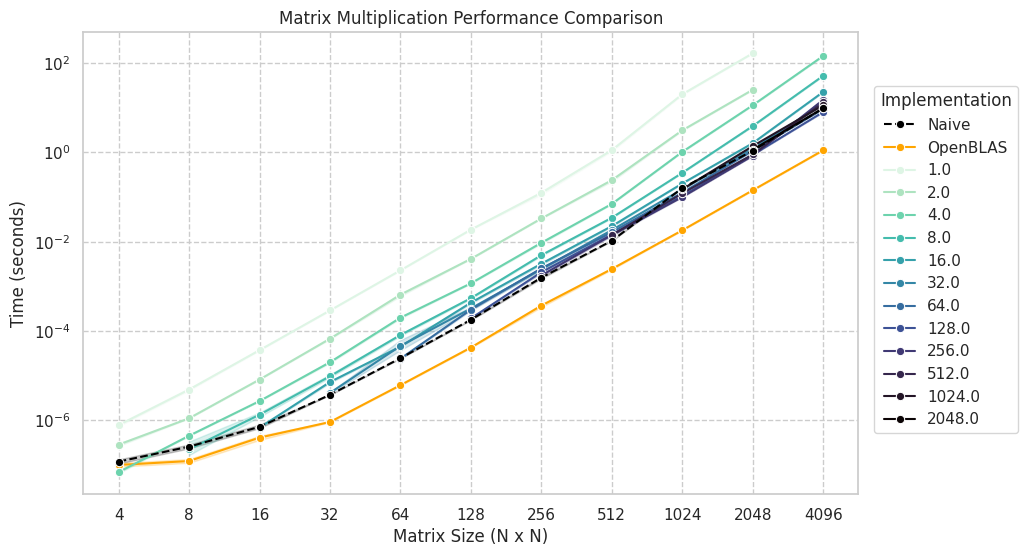

In [ ]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=naive_results,
    x="size",
    y="time",
    marker="o",
    linestyle="--",
    ax=ax,
    label="Naive",
    color="black",
    zorder=3,
)

sns.lineplot(
    data=openblas_results,
    x="size",
    y="time",
    marker="o",
    ax=ax,
    label="OpenBLAS",
    color="orange",
)

sns.lineplot(
    data=blocked_results,
    x="size",
    y="time",
    hue='block_size',
    hue_norm=LogNorm(),
    palette="mako_r",
    legend="full",
    marker="o",
    ax=ax,
)

ax.set_title("Matrix Multiplication Performance Comparison")
ax.set_xlabel("Matrix Size (N x N)")
ax.set_ylabel("Time (seconds)")

ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)

# x ticks as powers of 2 in full number
ax.set_xticks(2 ** np.arange(2, 13))
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

ax.legend(title="Implementation", bbox_to_anchor=(1.01, 0.9), loc='upper left')

plt.grid(True, which="both", ls="--", lw=1)

plt.savefig("figures/matrix_multiplication_performance.pdf", bbox_inches='tight')

plt.tight_layout()
plt.show()


<Axes: xlabel='size', ylabel='speedup'>

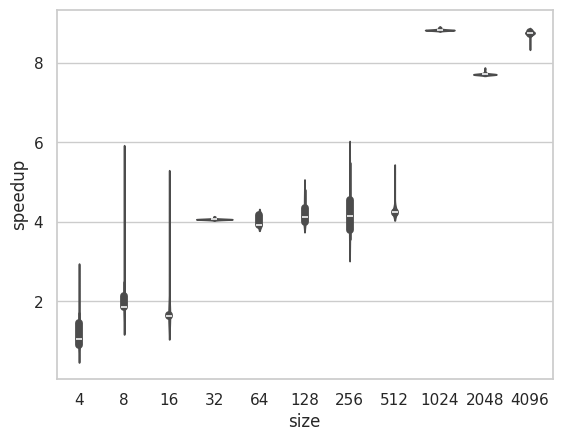

In [62]:
sns.violinplot(
    data=naive_results,
    x="size",
    y="speedup",
)


ValueError: Could not interpret value `speedup` for `y`. An entry with this name does not appear in `data`.

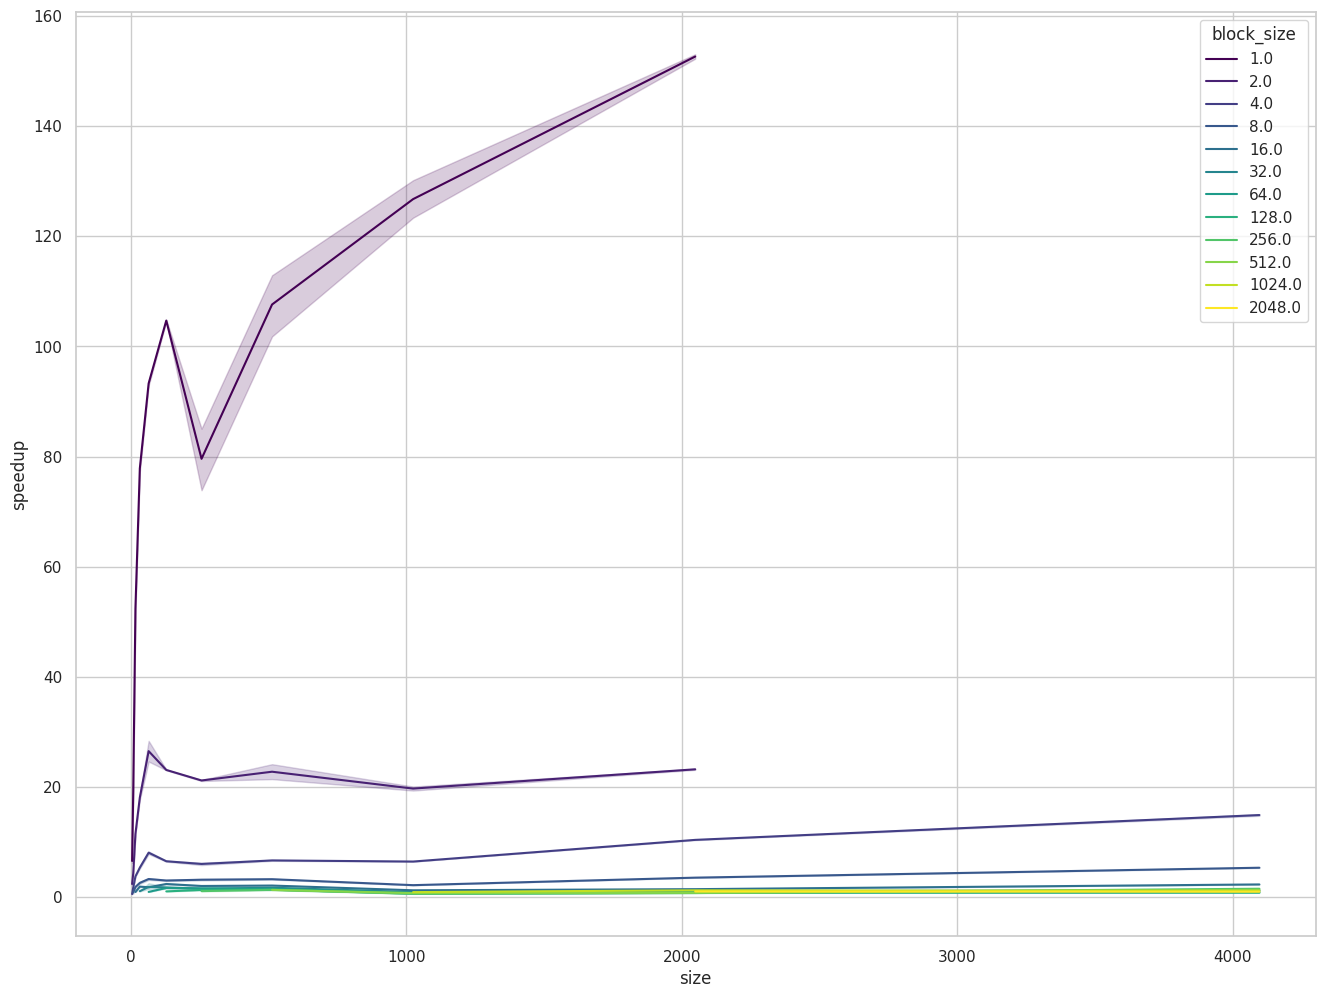

In [144]:
fig, ax = plt.subplots(figsize=(16, 12))



# Set hue to log scale for better color distribution
from matplotlib.colors import LogNorm

sns.lineplot(
    data=blocked_results,
    x="size",
    y="speedup",
    hue="block_size",
    hue_norm=LogNorm(),
    # marker="o",
    palette="viridis",
    legend="full",
    ax=ax,
)

sns.lineplot(
    data=naive_results,
    x="size",
    y="speedup",
    marker="o",
    linestyle="--",
    label="Naive",
    color="black",
    ax=ax,
)

plt.loglog(base=2)